# Attention Architecture

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import music21

In [3]:
from fastai.text import *
from enum import Enum
import torch
from fastai.text.models.awd_lstm import *
from fastai.text.models.transformer import *

In [4]:
np.set_printoptions(edgeitems=10, threshold=40, linewidth=200)

In [5]:
from fastai_data import *

In [6]:
import numpy as np
import torch.nn as nn

In [7]:
from encode_data import *

In [8]:
bs=16
bptt=256

In [9]:
MaskType = Enum('MaskType', 'NoMask Sequential RandomWindow Bert')

In [10]:
import fastai_data
fastai_data.Y_OFFSET=1
# fastai_data.VAL_OFFSET=1

In [11]:
np.random.rand()

0.42204508479517755

In [12]:
def rand_transpose(t, p=0.5):
    t = t.copy()
    notes = t[...,0]
    if np.random.rand() < p:
        notes[notes >= ENC_OFFSET] += np.random.randint(0,24)-12
#         notes[notes >= ENC_OFFSET] += np.random.randint(0,12)-5
    return t

In [13]:
path = Path('data/midi/v9/midi_encode/np/shortdur/')
data = LMNPDataBunch.load(path, bs=bs, bptt=bptt, cache_name='tmp/hook', train_tfms=[rand_transpose])
# data = LMNPDataBunch.load(path, bs=bs, bptt=bptt, cache_name='tmp/dump')

In [14]:
PAD_IDX=PADDING_IDX+ENC_OFFSET

In [15]:
max_vocab_file = path/'tmp/all/max_vocab.npy'
if max_vocab_file.exists():
    VOCAB_SZ = np.load(max_vocab_file).tolist()
else:
    train_ids_file = path/'tmp/all/train_ids.npy'
    all_ids = np.load(train_ids_file)
    id_cat = np.concatenate(all_ids); id_cat.shape
    ax = tuple(range(len(id_cat.shape)-1))
    max_vocab = id_cat.max(axis=ax)+1
    np.save(max_vocab_file, max_vocab)
    VOCAB_SZ = max_vocab.tolist()
VOCAB_SZ

[130, 132]

In [16]:
N_BAR = 1
N_COMPS = len(VOCAB_SZ)
N_EMBS = 128
EMB_IDXS = range(N_COMPS)
EMB_DIM = [N_EMBS]*len(EMB_IDXS)
EMB_MAP = list(zip(EMB_IDXS,VOCAB_SZ,EMB_DIM))
LOSS_WEIGHTS = [1,1,1]
EMB_MAP

[(0, 130, 128), (1, 132, 128)]

In [17]:
idx2embidx = { i:EMB_MAP[i] for i in range(N_COMPS) }

In [18]:
config = tfmerXL_lm_config

In [19]:
config['emb_map'] = EMB_MAP
config['idx_map'] = idx2embidx
config['mask_type'] = MaskType.RandomWindow
# config['mask_type'] = MaskType.Sequential

In [20]:
total_embs = sum([v[-1] for k,v in idx2embidx.items()])
config['d_model'] = total_embs * N_BAR

In [21]:
config['mem_len'] = 512
# config['ctx_len'] = 512 # for learned positional encoding
# config['d_inner'] = config['d_model'] * 4

In [22]:
config['resid_p'] = 0.2
config['attn_p'] = 0.2
config['ff_p'] = 0.2
config['embed_p'] = 0.2
config['output_p'] = 0.2

In [23]:
config

{'ctx_len': 150,
 'n_layers': 12,
 'n_heads': 10,
 'd_model': 256,
 'd_head': 41,
 'd_inner': 2100,
 'resid_p': 0.2,
 'attn_p': 0.2,
 'ff_p': 0.2,
 'embed_p': 0.2,
 'output_p': 0.2,
 'bias': False,
 'scale': True,
 'act': <Activation.ReLU: 1>,
 'double_drop': True,
 'tie_weights': True,
 'out_bias': True,
 'init': <function fastai.text.models.transformer.init_transformer(m)>,
 'mem_len': 512,
 'mask': True,
 'emb_map': [(0, 130, 128), (1, 132, 128)],
 'idx_map': {0: (0, 130, 128), 1: (1, 132, 128)},
 'mask_type': <MaskType.RandomWindow: 3>}

In [24]:
# # BERT config
# config['mask_type'] = MaskType.Bert
# config['mem_len'] = 0
# config['d_model'] = N_EMBS

In [25]:
class TransformerEmbed(nn.Module):
    def __init__(self, emb_map, idx_map, embed_p:float=0.1, **kwargs):
        super().__init__()
        # note, octave, duration, instrument
        self.idx_map = idx_map
        self.emb_map = emb_map
        embeddings = []
        for idx,in_d,out_d in emb_map:
            embeddings.append(nn.Embedding(in_d, out_d, padding_idx=PAD_IDX))
        self.embeddings = nn.ModuleList(embeddings)
        self.drop_emb = nn.Dropout(embed_p)
        
    def forward(self, x):
        # batch x bptt x (n,o,d,i)
        embs = []
        for i in range(x.shape[-1]):
            emb_idx = self.idx_map[i][0]
            embx = self.embeddings[emb_idx](x[...,i])
            embs.append(embx)
        emb = torch.stack(embs, dim=-2) # barlen x comp x emb
#         emb = emb.permute(0,1,4,2,3) # for conv - emb x barlen x comp
        return self.drop_emb(emb)

In [26]:
class TXLLinearDecoder(nn.Module):
    "To go on top of a RNNCore module and create a Language Model."
    initrange=0.1

    def __init__(self, tie_encoder:nn.Module=None, bias:bool=True, input_dim=None):
        super().__init__()
        n_hid,n_out = tie_encoder.embedding_dim, tie_encoder.num_embeddings
        self.decoder = nn.Linear(n_hid, n_out, bias=bias)
        self.decoder.weight.data.uniform_(-self.initrange, self.initrange)
        if bias: self.decoder.bias.data.zero_()
        if tie_encoder: self.decoder.weight = tie_encoder.weight
            
        if input_dim is not None and input_dim != n_hid:
            self.decoder = nn.Sequential(nn.Linear(input_dim, n_hid), self.decoder)

    def forward(self, input):
        return self.decoder(input)

In [27]:
class TransformerDec(nn.Module):
    def __init__(self, txl_emb, idx_map, output_p=0.0, out_bias=True, d_model=None, **kwargs):
        super().__init__()
        self.output_dp = RNNDropout(output_p)
        
        decoders = []
        for k,v in idx_map.items():
            emb = txl_emb.embeddings[v[0]]
            decoder = TXLLinearDecoder(tie_encoder=emb, bias=out_bias, input_dim=d_model)
            decoders.append(decoder)
            
        self.decoders = nn.ModuleList(decoders)
        
    def forward(self, input):
        raw_outputs, outputs = input
        output = self.output_dp(outputs[-1])
        res = []
        for idx,dec in enumerate(self.decoders):
            res.append(dec(output))
        return res, raw_outputs, outputs

In [28]:

def rand_window_mask(x_len,m_len,device,p=0.2,is_eval=False):
    if is_eval or m_len == 0 or np.random.rand() >= p: 
        win_size,k = (1,1)
    else: win_size,k = (np.random.randint(0,3)+1,0)
        
    mem_mask = np.zeros((x_len,m_len))
    tri_mask = np.triu(np.ones((x_len//win_size+1,x_len//win_size+1)),k=k)
    window_mask = tri_mask.repeat(win_size,axis=0).repeat(win_size,axis=1)[:x_len,:x_len]
    np_mask = np.concatenate((mem_mask, window_mask), axis=1)
    mask = torch.tensor(np_mask, device=device).byte()[None,None]; mask
    return mask

In [29]:

class LMNPTransformerXL(nn.Module):
    "TransformerXL model: https://arxiv.org/abs/1901.02860."
    def __init__(self, encoder, ctx_len:int, n_layers:int, n_heads:int, d_model:int, d_head:int, d_inner:int, 
                 resid_p:float=0., attn_p:float=0., ff_p:float=0., embed_p:float=0., bias:bool=False, scale:bool=True,
                 act:Activation=Activation.ReLU, double_drop:bool=True, attn_cls:Callable=MultiHeadRelativeAttention,
                 learned_pos_enc:bool=False, mask_type:MaskType=MaskType.Sequential, mem_len:int=0, **kwargs):
        super().__init__()
        self.encoder = encoder
        self.pos_enc = nn.Embedding(ctx_len, d_model) if learned_pos_enc else PositionalEncoding(d_model)
        self.u = nn.Parameter(torch.Tensor(n_heads, 1, d_head)) #Remove 1 for einsum implementation of attention
        self.v = nn.Parameter(torch.Tensor(n_heads, 1, d_head)) #Remove 1 for einsum implementation of attention
        self.mem_len,self.n_layers,self.d_model,self.mask_type = mem_len,n_layers,d_model,mask_type
        self.init = False
        self.layers = nn.ModuleList([DecoderLayer(n_heads, d_model, d_head, d_inner, resid_p=resid_p, attn_p=attn_p,
                      ff_p=ff_p, bias=bias, scale=scale, act=act, double_drop=double_drop, 
                      attn_cls=attn_cls) for k in range(n_layers)])
    
    def reset(self):
        "Reset the internal memory."
        self.hidden = [next(self.parameters()).data.new(0) for i in range(self.n_layers+1)]

    def _update_mems(self, hids):
        if not getattr(self, 'hidden', False): return None
        assert len(hids) == len(self.hidden), 'len(hids) != len(self.hidden)'
        with torch.no_grad():
            for i in range(len(hids)):
                cat = torch.cat([self.hidden[i], hids[i]], dim=1)
                self.hidden[i] = cat[:,-self.mem_len:].detach()
    
    def select_hidden(self, idxs): self.hidden = [h[idxs] for h in self.hidden]
    
    def forward(self, x):
        #The hidden state has to be initiliazed in the forward pass for nn.DataParallel
        if self.mem_len > 0 and not self.init: 
            self.reset()
            self.init = True
        inp = self.encoder(x)
        if self.mask_type.value == MaskType.Bert.value:
            inp = inp.reshape(inp.shape[0], -1, inp.shape[-1]) # bs,bptt,comp,emb -> bs,bptt*comp,emb
        else:
            inp = inp.reshape(*inp.shape[:2], -1) # bs,bptt,comp,emb -> bs,bptt,comp,emb
        bs,x_len = inp.shape[:2]
        m_len = self.hidden[0].size(1) if hasattr(self, 'hidden') and len(self.hidden[0].size()) > 1 else 0
        seq_len = m_len + x_len
        
        if self.mask_type.value == MaskType.NoMask.value: 
            self.mask = None
        elif self.mask_type.value == MaskType.Sequential.value: 
            self.mask = torch.triu(x.new_ones(x_len, seq_len), diagonal=1+m_len).byte()[None,None]
        elif self.mask_type.value == MaskType.RandomWindow.value: 
            self.mask = rand_window_mask(x_len,m_len,x.device,is_eval=not self.training)
        else: 
            raise ValueError('Unhandled mask type:', self.mask_type)
            
        #[None,:,:None] for einsum implementation of attention
        hids = []
        pos = torch.arange(seq_len-1, -1, -1, device=inp.device, dtype=inp.dtype)
        pos_enc = self.pos_enc(pos)
        hids.append(inp)
        for i, layer in enumerate(self.layers):
            mem = self.hidden[i] if self.mem_len > 0 else None
            inp = layer(inp, r=pos_enc, u=self.u, v=self.v, mask=self.mask, mem=mem)
            hids.append(inp)
        core_out = inp[:,-x_len:]
        if self.mem_len > 0 : self._update_mems(hids)
        return (self.hidden if self.mem_len > 0 else [core_out]),[core_out]

In [30]:
def get_language_model(config:dict=None, drop_mult:float=1.):
    "Create a language model from `arch` and its `config`, maybe `pretrained`."
    for k in config.keys(): 
        if k.endswith('_p'): config[k] *= drop_mult
    init = config.pop('init') if 'init' in config else None
    
    embed = TransformerEmbed(**config)
    txl = LMNPTransformerXL(embed, **config)
    decoder = TransformerDec(embed, **config)
    model = SequentialRNN(txl, decoder)
    
    return model if init is None else model.apply(init)


def language_model_learner(data:DataBunch, config:dict=None, drop_mult:float=1., pretrained:bool=True,
                           **learn_kwargs) -> 'LanguageLearner':
    "Create a `Learner` with a language model from `data` and `arch`."
    model = get_language_model(config=config, drop_mult=drop_mult)
    learn = LanguageLearner(data, model, split_func=tfmer_lm_split, **learn_kwargs)
    return learn

In [31]:
class LMNPLoss(nn.Module):
    "Same as `func`, but flattens input and target."
    def __init__(self):
        super().__init__()
        self.fn = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
        # not using func otherwise _loss_func_name2activ uses this attribute to get cross entropy loss

    def __repr__(self): return f"numpyenc loss of {self.fn}"

    def forward(self, inputs:Tensor, target:Tensor, **kwargs)->Rank0Tensor:
        losses = []
        for idx,input in enumerate(inputs):
#             if idx in CIDX_ALL: continue
            t = target[...,idx]
            input = input.view(-1,input.shape[-1])
            losses.append(self.fn(input, t.view(-1))*LOSS_WEIGHTS[idx])
        return sum(losses)

In [32]:
def lmnp_accuracy(inputs:Tensor, target:Tensor)->Rank0Tensor:
    "Compute accuracy with `targs` when `input` is bs * n_classes."
    inputs = [i.argmax(dim=-1).unsqueeze(dim=-1) for i in inputs]
    input = torch.cat(inputs, dim=-1)
    target = target.view(input.shape)
    
    acc = (input==target).float().cpu().numpy()
    acc[target==PAD_IDX] = np.nan
    return torch.tensor(np.nanmean(acc), device=target.device)

In [33]:
learn = language_model_learner(data, config, clip=0.25, loss_func=LMNPLoss(), metrics=[lmnp_accuracy])

In [34]:
x,y = data.one_batch(cpu=False)

In [35]:
# ob = data.one_batch(cpu=False)
# out = learn.model(ob[0])
# out = learn.pred_batch(ob)
# learn.loss_func([c.cuda() for c in out], ob[1])

In [36]:
# # # clip = 0.5
# learn.lr_find(num_it=300)
# learn.recorder.plot()

In [37]:
# learn.to_fp16();

In [38]:
# learn.fit_one_cycle(4, 2e-4)

In [39]:
# learn.save('first_run_10ep')

In [40]:
# learn.fit_one_cycle(5, 2e-4)

In [41]:
models = get_files(path/'models/hook', recurse=True); models

[PosixPath('data/midi/v9/midi_encode/np/shortdur/models/hook/1_epoch20_best.pth'),
 PosixPath('data/midi/v9/midi_encode/np/shortdur/models/hook/v9_1_epoch20_best.pth'),
 PosixPath('data/midi/v9/midi_encode/np/shortdur/models/hook/v9_1_epoch20.pth'),
 PosixPath('data/midi/v9/midi_encode/np/shortdur/models/hook/1_epoch20.pth')]

In [42]:
load_path = Path('data/midi/v9/midi_encode/np/shortdur/models/hook/v9_1_epoch20.pth')
state = torch.load(load_path, map_location='cpu')
get_model(learn.model).load_state_dict(state['model'], strict=False)
learn.model.cuda()

SequentialRNN(
  (0): LMNPTransformerXL(
    (encoder): TransformerEmbed(
      (embeddings): ModuleList(
        (0): Embedding(130, 128, padding_idx=0)
        (1): Embedding(132, 128, padding_idx=0)
      )
      (drop_emb): Dropout(p=0.2)
    )
    (pos_enc): PositionalEncoding()
    (layers): ModuleList(
      (0): DecoderLayer(
        (mhra): MultiHeadRelativeAttention(
          (attention): Linear(in_features=256, out_features=1230, bias=False)
          (out): Linear(in_features=410, out_features=256, bias=False)
          (drop_att): Dropout(p=0.2)
          (drop_res): Dropout(p=0.2)
          (ln): LayerNorm(torch.Size([256]), eps=1e-05, elementwise_affine=True)
          (r_attn): Linear(in_features=256, out_features=410, bias=False)
        )
        (ff): SequentialEx(
          (layers): ModuleList(
            (0): Linear(in_features=256, out_features=2100, bias=True)
            (1): ReLU(inplace)
            (2): Dropout(p=0.2)
            (3): Linear(in_features=21

In [43]:
from fastai import basic_train

In [44]:
def predict_func(parts): return [F.softmax(p, dim=-1) for p in parts]

In [45]:
loss_func_name = camel2snake(learn.loss_func.__class__.__name__)
basic_train.loss_func_name2activ[loss_func_name] = predict_func
basic_train._loss_func2activ(learn.loss_func)

<function __main__.predict_func(parts)>

In [126]:
# bos_idx = enc_config.enc_offset+enc_config.bos_idx
bos_idx = VALTBOS+ENC_OFFSET

def predict(self, xb, n_words:int=1, temperature:float=1., min_p:float=None):
    "Return the `n_words` that come after `text`."
    ds = self.data.single_dl.dataset
    self.model.reset()
    learn.model[0].mask = False
    if xb.shape[0] > 1: xb = xb[0][None]
    seed = xb.cpu().numpy()
    yb = torch.ones_like(xb)
    timesteps = []
    for _ in progress_bar(range(n_words), leave=True):
        bar = []
        outputs = learn.pred_batch(batch=(xb,yb))
        for item in outputs: #progress_bar(range(n_words), leave=False):
            res = item[0][-1]
            if min_p is not None: 
                if (res >= min_p).float().sum() == 0:
                    warn(f"There is no item with probability >= {min_p}, try a lower value.")
                else: res[res < min_p] = 0.
            if temperature != 1.: res.pow_(1 / temperature)
            idx = torch.multinomial(res, 1)
#             val,idx = torch.topk(res, 1)
            bar.append(idx.squeeze().to(xb.device))
        bar = torch.stack(bar, dim=-1)
        if (bar==bos_idx).any(): 
            print('Predicted BOS token. Returning prediction...')
            break
        timesteps.append(bar.cpu().numpy())
        xb = bar.clone().detach()[None,None] # don't use timesteps. use it's own memory instead
    
    learn.model[0].mask = True
    return timesteps, seed.squeeze()


In [149]:
def pred2stream(arr):
    seq = npenc2seq(np.array(arr))
    chordarr = seq2chordarr(seq)
    return chordarr2stream(chordarr)

### From batch

In [127]:
xb,yb = learn.data.one_batch(cpu=False)

### From song

In [128]:
seed_len = 60
files = get_files(path/'hooktheory', extensions=['.npy'], recurse=True)

In [129]:
# Loading from specific file
keywords = ['third', 'eye']
def contains_keywords(f): return all([k in str(f) for k in keywords])
search = [f for f in files if contains_keywords(f)]; search

[PosixPath('data/midi/v9/midi_encode/np/shortdur/hooktheory/pianoroll/z/zun/satori-maiden---third-eye/verse-and-pre-chorus_key_cmajor.npy'),
 PosixPath('data/midi/v9/midi_encode/np/shortdur/hooktheory/pianoroll/z/zun/satori-maiden---third-eye/chorus_key_cmajor.npy'),
 PosixPath('data/midi/v9/midi_encode/np/shortdur/hooktheory/pianoroll/t/third-eye-blind/jumper/chorus_key_cmajor.npy'),
 PosixPath('data/midi/v9/midi_encode/np/shortdur/hooktheory/pianoroll/t/third-eye-blind/never-let-you-go/verse-and-pre-chorus_key_cmajor.npy'),
 PosixPath('data/midi/v9/midi_encode/np/shortdur/hooktheory/pianoroll/t/third-eye-blind/never-let-you-go/chorus_key_cmajor.npy'),
 PosixPath('data/midi/v9/midi_encode/np/shortdur/hooktheory/pianoroll/t/third-eye-blind/hows-it-going-to-be/intro_key_cmajor.npy'),
 PosixPath('data/midi/v9/midi_encode/np/shortdur/hooktheory/pianoroll/t/third-eye-blind/hows-it-going-to-be/verse_key_cmajor.npy'),
 PosixPath('data/midi/v9/midi_encode/np/shortdur/hooktheory/pianoroll/t/th

In [130]:
# file = np.random.choice(files)
file = search[-1]
file

PosixPath('data/midi/v9/midi_encode/np/shortdur/hooktheory/pianoroll/t/third-eye-blind/semi-charmed-life/chorus_key_cmajor.npy')

In [131]:
#good_one = Path('data/midi/v7/midi_encode/np/hook_1bar_nopos/hooktheory/c/cool-and-new-web-comic/tick---tock/chorus.npy')
file = Path('data/midi/v9/midi_encode/np/shortdur/hooktheory/pianoroll/r/ritchie-valen/la-bamba/chorus_key_cmajor.npy')
# third_eye = Path('data/midi/v7/midi_encode/np/hook_1bar_nopos/hooktheory/t/third-eye-blind/semi-charmed-life/chorus.npy')

In [132]:
seed_np = np.load(file)[:seed_len]
xb = torch.tensor(seed_np).cuda()[None]

### Predict

In [133]:
out, seed = predict(learn, xb, n_words=340, temperature=1, min_p=0.01)

Predicted BOS token. Returning prediction...


### Actual prediction

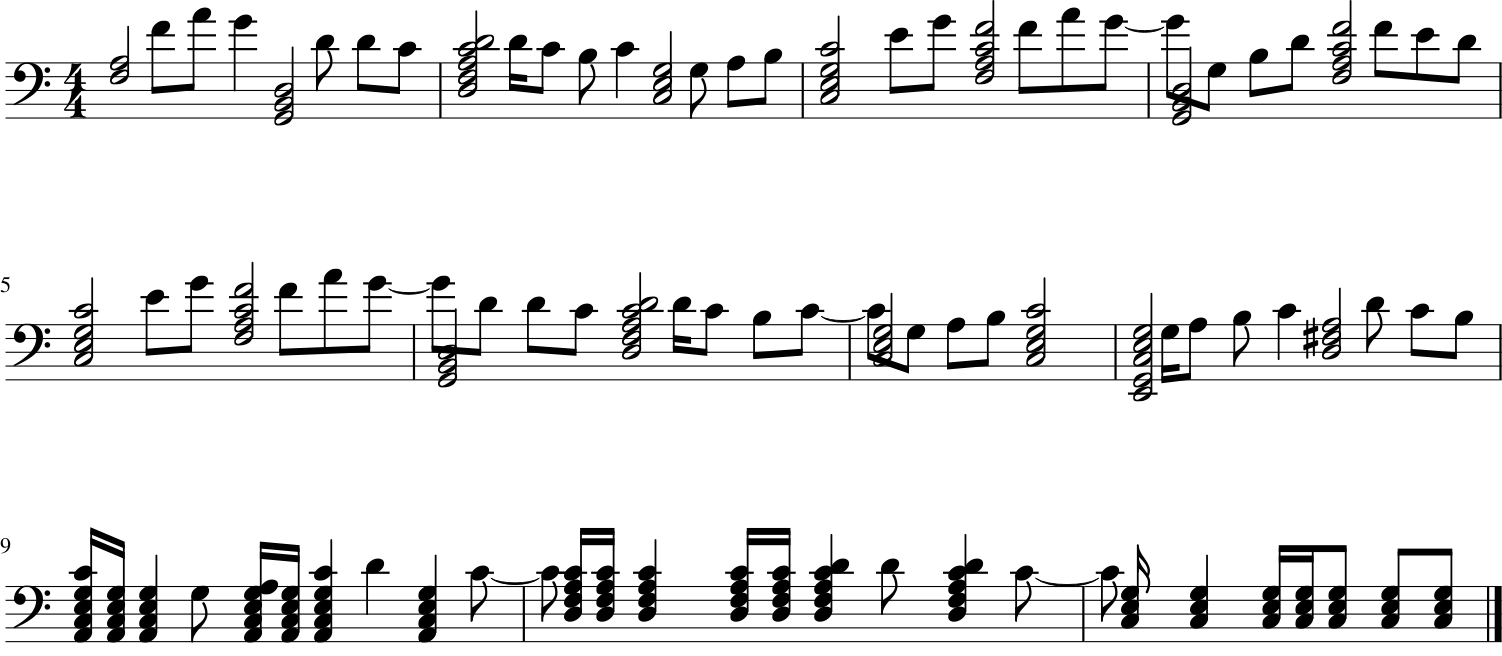

In [150]:
stream = pred2stream(out)
stream.show()

In [151]:
stream.show('midi')

## Seed

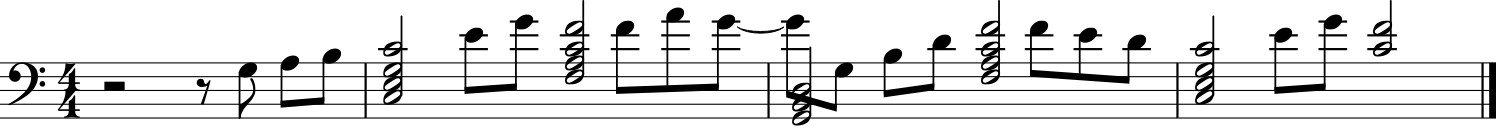

In [152]:
seed_stream = pred2stream(seed)
seed_stream.show()

In [153]:
seed_stream.show('midi')

## Alltogether now

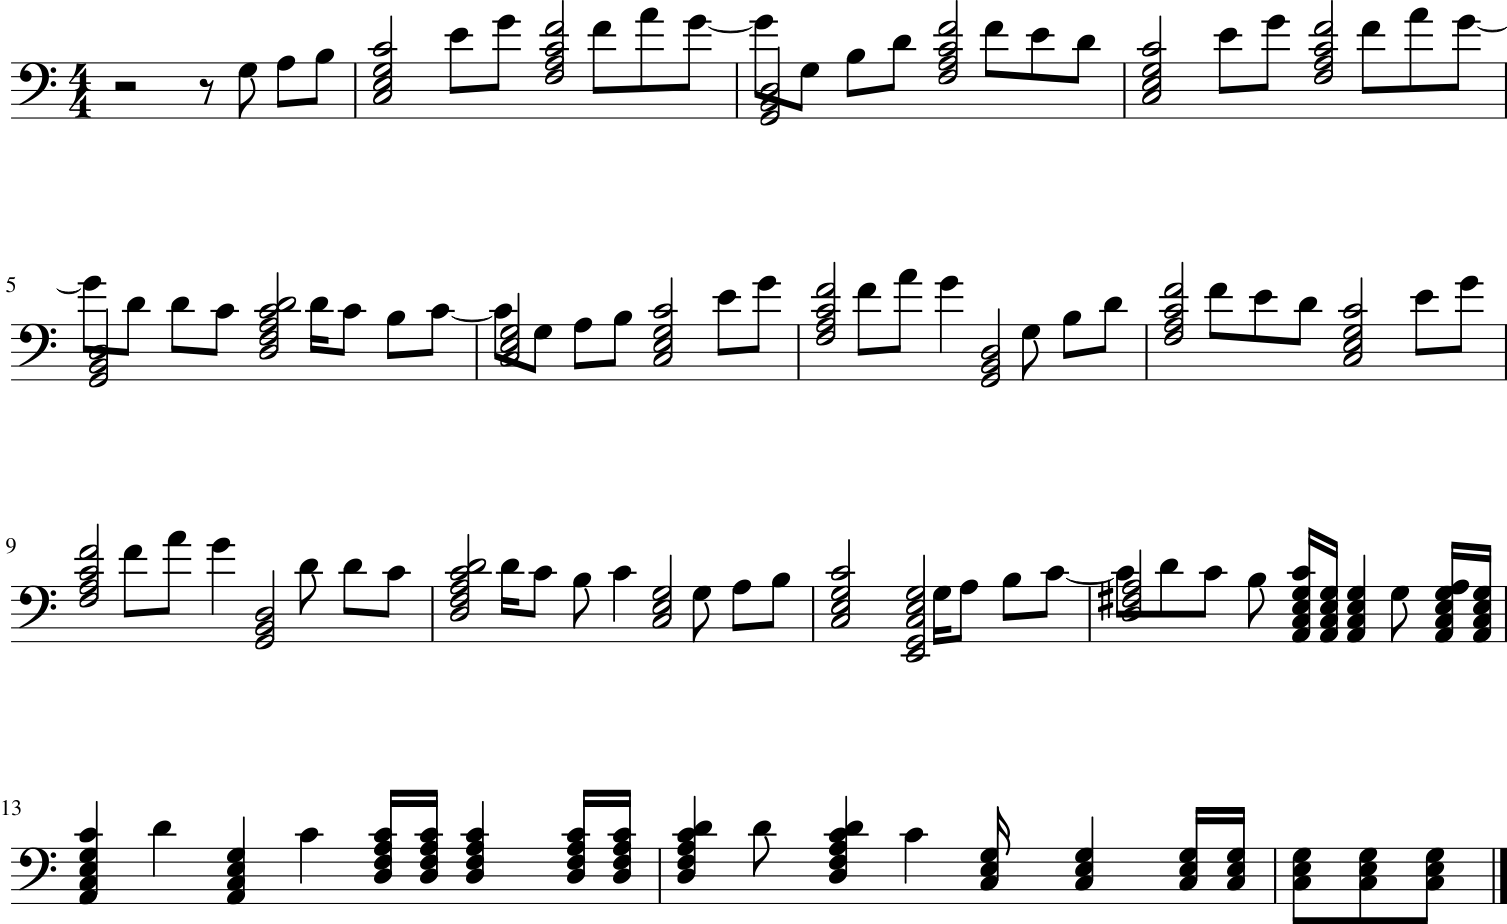

In [156]:
full_output = np.concatenate((seed,out), axis=0)
full_stream = pred2stream(full_output)
full_stream.show()

In [157]:
full_stream.show('midi')